In [1]:
import os
import re
import sys

import json

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import Point
from functools import reduce

from prettyprinter import pprint

In [2]:
from pathlib import Path

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from plotnine import *
from plotnine import options as opt

In [4]:
sns.set()

---

In [5]:
# flat data directory
DATA_PATH = Path("data/raw/data.csv")

# shape files
CR_KRAJE_SHAPE = Path("data/geo/Kraje__polygony.shp")

---

In [6]:
df = pd.read_csv(DATA_PATH)
df = df.drop_duplicates()

In [7]:
df.head(1)

,Cena,Další vybavení,Dispozice,Druh,Energetická náročnost budovy,K nastěhování,Kauce,Měsíční poplatky,Podlaží,Poznámka,Pronájem přidán,Provize realitní kanceláře,Vybavený,Výměra,data-id,data-idx,geo-lat,geo-lng,id
0,dohodou,Balkón,dům,Pronájem,G - Mimořádně nehospodárná,NaN,NaN,NaN,NaN,Cena k jednání,před 5 měsíci,Info u RK,Částečně,250 m2,2645624,0,50.01704,14.22649,#offer-0


In [8]:
df.describe()

,data-id,data-idx,geo-lat,geo-lng
count,4.648000e+03,4648.000000,4648.000000,4648.000000
mean,2.881282e+06,9.256454,49.965848,15.160050
std,4.038130e+05,5.727630,0.338683,1.442249
min,9.580320e+05,0.000000,48.751310,12.177620
25%,2.928930e+06,4.000000,49.870870,14.406227
50%,3.055436e+06,9.000000,50.072020,14.441730
75%,3.066128e+06,14.000000,50.090830,15.834718
max,3.076384e+06,19.000000,50.782990,18.625720


# GeoViz

In [9]:
CRS_EPSG = 4326

In [10]:
geo_df = gpd.read_file(CR_KRAJE_SHAPE, encoding='utf-8')
geo_df.to_crs(epsg=CRS_EPSG, inplace=True)  # convert to WSG84
geo_df.head()

,OBJECTID,KOD_KRAJ,KOD_CZNUTS,NAZ_CZNUTS,POCET_OB_9,POCET_OB_0,POCET_OB_1,SNATKY,ROZVODY,NAROZENI,...,MIRA_NEZ_2,MZDA,ROZDIL_MZD,NADEJE_DOZ,NADEJE_D_1,SX,SY,SHAPE_Leng,SHAPE_Area,geometry
0,1,3018,CZ010,Hlavní město Praha,1214174,1169106,1268796,5531,3002,13867,...,5.088291,32879,-525,77.32,82.08,1043300,743100,1.614855e+05,4.961742e+08,"POLYGON ((14.53328412678415 50.17688041057585,..."
1,2,3026,CZ020,Středočeský kraj,1112882,1122473,1289211,5252,3793,14218,...,6.970058,25001,200,75.20,80.88,1033266,764439,1.166855e+06,1.101627e+10,"POLYGON ((14.91620834165124 50.61931781257647,..."
2,3,3034,CZ031,Jihočeský kraj,622889,625267,628336,2600,1747,6374,...,7.023135,22443,126,75.38,80.93,1166165,755832,8.909783e+05,1.005809e+10,"POLYGON ((14.06385339794907 49.56279655094983,..."
3,4,3042,CZ032,Plzeňský kraj,558307,550688,570401,2367,1613,5510,...,6.643277,23866,73,75.52,80.89,1069700,822400,6.681103e+05,7.560741e+09,"POLYGON ((13.32477396551897 50.10241196379821,..."
4,5,3051,CZ041,Karlovarský kraj,301985,304343,295595,1300,879,2826,...,8.753195,21435,86,74.11,80.01,1012216,849146,4.676178e+05,3.313922e+09,"POLYGON ((12.82237355429952 50.45992686796461,..."


In [11]:
df['geometry'] = list(zip(df['geo-lng'],
                          df['geo-lat']))

df['geometry'] = df['geometry'].apply(Point)

df = gpd.GeoDataFrame(df, crs={'init': f'epsg:{CRS_EPSG}'}, geometry='geometry')  # set initial crs

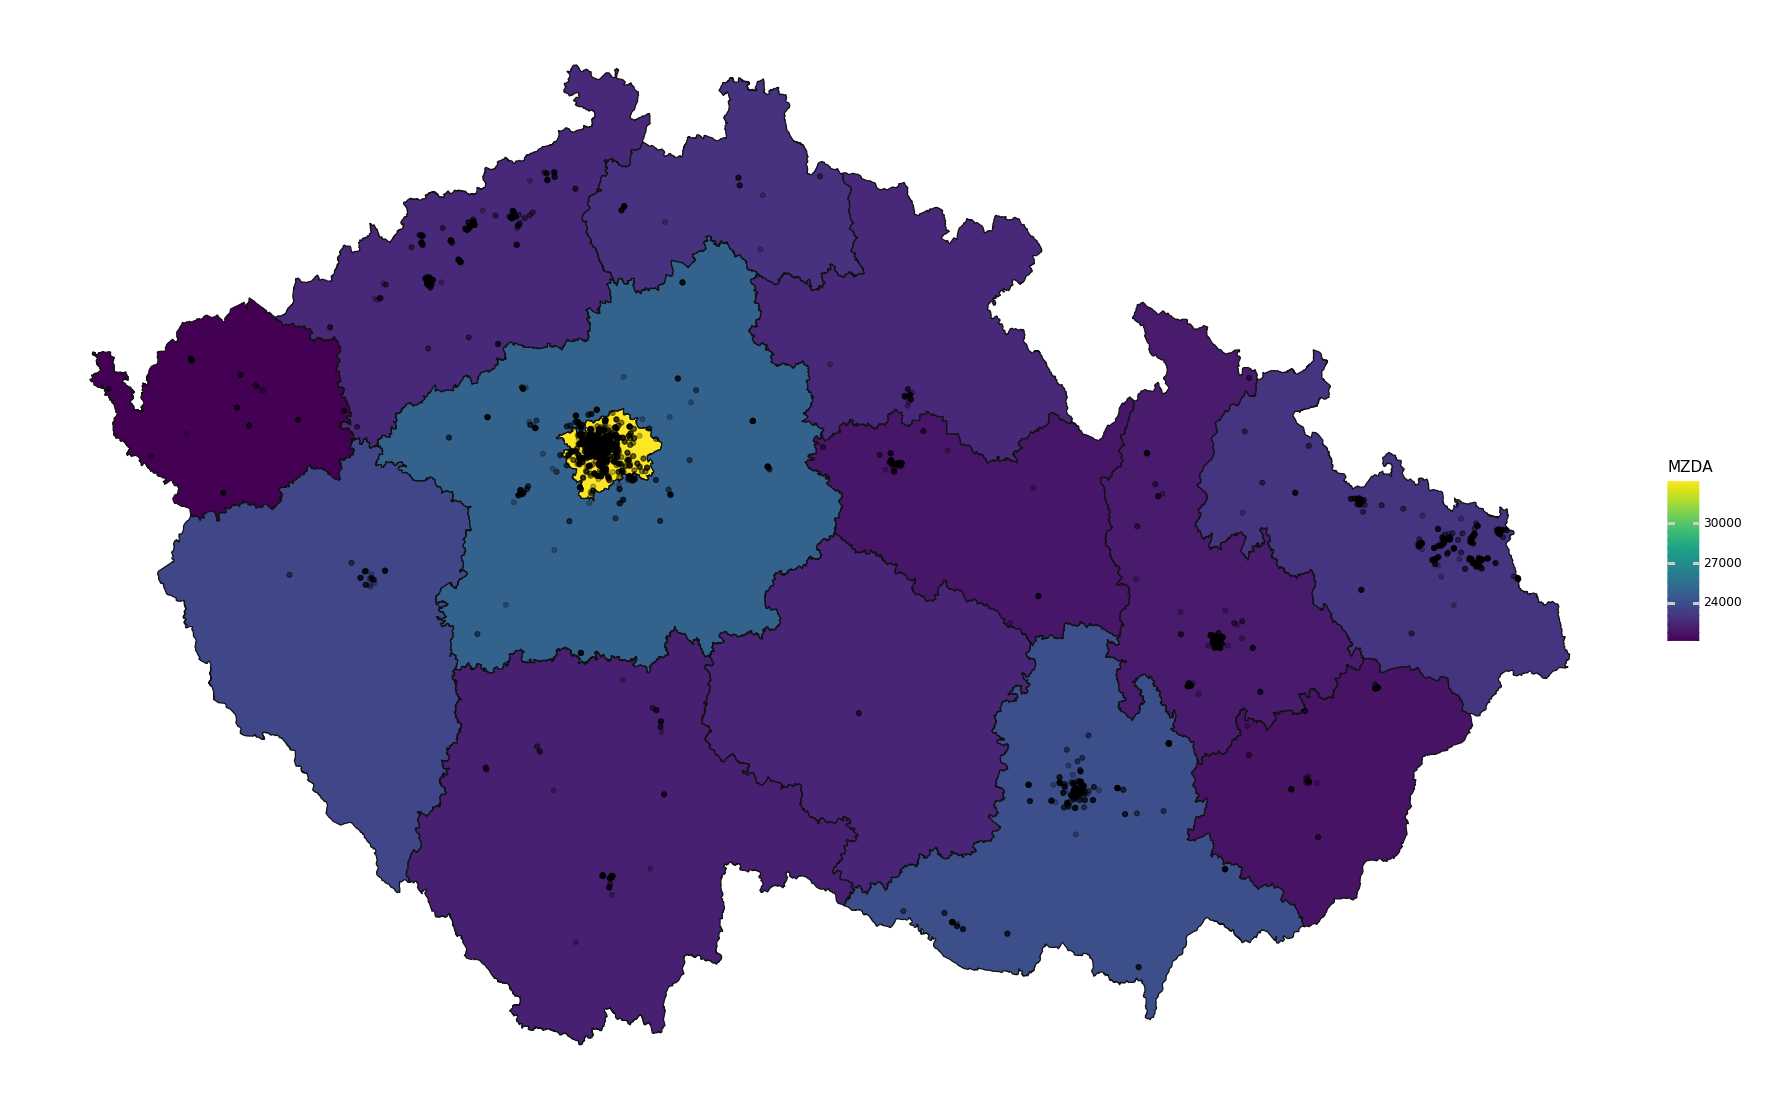

<ggplot: (-9223363295458194488)>

In [12]:
opt.figure_size = (21, 14)

(ggplot(geo_df)
 + geom_map(aes(fill='MZDA'))
 + geom_point(df, aes(x='geometry.x', y='geometry.y'), alpha=0.25)
 + theme_void()
)

# Data preprocessing

In [13]:
df.drop(['id', 'data-id', 'data-idx', 'Druh', 'K nastěhování'], axis=1, inplace=True)

In [14]:
df.head()

,Cena,Další vybavení,Dispozice,Energetická náročnost budovy,Kauce,Měsíční poplatky,Podlaží,Poznámka,Pronájem přidán,Provize realitní kanceláře,Vybavený,Výměra,geo-lat,geo-lng,geometry
0,dohodou,Balkón,dům,G - Mimořádně nehospodárná,NaN,NaN,NaN,Cena k jednání,před 5 měsíci,Info u RK,Částečně,250 m2,50.01704,14.22649,POINT (14.22649 50.01704)
1,dohodou,Sklep,2+1,G - Mimořádně nehospodárná,NaN,NaN,3. patro,Cena nájmu dohodou,před 2 měsíci,Info u RK,Částečně,54 m2,49.19280,14.71803,POINT (14.71803 49.1928)
2,dohodou,NaN,3+kk,G - Mimořádně nehospodárná,1 Kč,1 Kč/měsíc,7. patro,NaN,před 9 měsíci,Ano,Částečně,85 m2,49.60008,17.21948,POINT (17.21947999999999 49.60008)
3,dohodou,NaN,2+kk,G - Mimořádně nehospodárná,NaN,NaN,1. patro,"+ služby cca 1 800,-Kč, kauce ve výši 40 000,-Kč",před měsícem,Info u RK,Vůbec,45 m2,49.46335,17.97244,POINT (17.97244 49.46335)
4,dohodou,NaN,2+kk,G - Mimořádně nehospodárná,NaN,NaN,1. patro,"+ služby cca 1 800,-Kč, kauce ve výši 40 000,-Kč",před měsícem,Info u RK,Vůbec,48 m2,49.46335,17.97244,POINT (17.97244 49.46335)


### Categorical variables

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
categorical_vars = ['Dispozice', 'Energetická náročnost budovy', 'Podlaží', 'Vybavený']

In [17]:
col = 'Dispozice'

encoder_disp = LabelEncoder()
df[col] = encoder_disp.fit_transform(df[col])

In [18]:
col = 'Energetická náročnost budovy'

df[col] = df[col].str[0].astype('category')

encoder_enb = LabelEncoder()
df[col] = encoder_enb.fit_transform(df[col])

In [19]:
col = 'Podlaží'

df[col].fillna(df[col].describe().top, inplace=True)

encoder_pod = LabelEncoder()
df[col] = encoder_pod.fit_transform(df[col])

In [20]:
col = 'Vybavený'

encoder_vyb = LabelEncoder()
df[col] = encoder_vyb.fit_transform(df[col])

In [21]:
for col in categorical_vars:
    df[col].astype('category', copy=False)

In [22]:
df[categorical_vars].head(1)

,Dispozice,Energetická náročnost budovy,Podlaží,Vybavený
0,14,6,8,2


##### **Other:** Další vybavení

In [23]:
col = 'Další vybavení'

vybaveni = df.pop(col)

In [24]:
vybaveni = vybaveni.str.split(',', expand=True)
vybaveni = vybaveni.fillna(0)

In [25]:
vybaveni.columns = [c for c in vybaveni[0].unique() if c != 0]

In [26]:
for col in vybaveni.columns:
    vybaveni[col] = vybaveni[col].apply(lambda e: 1 if e == col else 0)

In [27]:
df = df.join(vybaveni)

##### **Other:** Provize realitní kanceláře

In [28]:
df.head()

,Cena,Dispozice,Energetická náročnost budovy,Kauce,Měsíční poplatky,Podlaží,Poznámka,Pronájem přidán,Provize realitní kanceláře,Vybavený,Výměra,geo-lat,geo-lng,geometry,Balkón,Sklep,Pračka,Lednice,Myčka
0,dohodou,14,6,NaN,NaN,8,Cena k jednání,před 5 měsíci,Info u RK,2,250 m2,50.01704,14.22649,POINT (14.22649 50.01704),1,0,0,0,0
1,dohodou,2,6,NaN,NaN,11,Cena nájmu dohodou,před 2 měsíci,Info u RK,2,54 m2,49.19280,14.71803,POINT (14.71803 49.1928),0,0,0,0,0
2,dohodou,5,6,1 Kč,1 Kč/měsíc,15,NaN,před 9 měsíci,Ano,2,85 m2,49.60008,17.21948,POINT (17.21947999999999 49.60008),0,0,0,0,0
3,dohodou,3,6,NaN,NaN,0,"+ služby cca 1 800,-Kč, kauce ve výši 40 000,-Kč",před měsícem,Info u RK,0,45 m2,49.46335,17.97244,POINT (17.97244 49.46335),0,0,0,0,0
4,dohodou,3,6,NaN,NaN,0,"+ služby cca 1 800,-Kč, kauce ve výši 40 000,-Kč",před měsícem,Info u RK,0,48 m2,49.46335,17.97244,POINT (17.97244 49.46335),0,0,0,0,0


In [29]:
col = 'Provize realitní kanceláře'

df[col] = df[col].apply(
    lambda e: 1 if pd.notna(e) and (any([s.isdigit() for s in e]) or e.startswith('Info')) else 0
)

### Parse column _'Poznámka'_:  __TODO__

In [30]:
df.drop('Poznámka', axis=1, inplace=True)

In [31]:
cols_to_fill = [
    col for col in df.columns
    if np.any(df[col].isna())
]

cols_to_fill

['Kauce', 'Měsíční poplatky', 'Pronájem přidán']

### Drop additional columns

In [32]:
df.drop('Pronájem přidán', axis=1, inplace=True)

### Discrete variables

In [33]:
discrete_vars = ['Cena', 'Kauce', 'Měsíční poplatky', 'Výměra']

In [34]:
df[discrete_vars].head(1)

,Cena,Kauce,Měsíční poplatky,Výměra
0,dohodou,NaN,NaN,250 m2


##### Kauce

In [35]:
def parse_bail(price_str: str) -> int:
    if pd.isna(price_str):
        return 0
    
    return int(price_str[:-len("Kč")].replace(" ", ""))

In [36]:
df.Kauce = df.Kauce.apply(parse_bail, convert_dtype='int')

##### Poplatky

In [37]:
def parse_fee(price_str: str) -> int:
    if pd.isna(price_str):
        return 0
    
    return int(price_str[:-len("Kč/měsíc")].replace(" ", ""))

In [38]:
df['Měsíční poplatky'] = df['Měsíční poplatky'].apply(parse_fee, convert_dtype='int')

##### Cena

In [39]:
from jenkspy import jenks_breaks

In [40]:
df.drop(df.Cena[df.Cena.values == 'dohodou'].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df['Cena'] = df['Cena'].apply(parse_fee, convert_dtype='int')

/home/macermak/.local/lib/python3.6/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


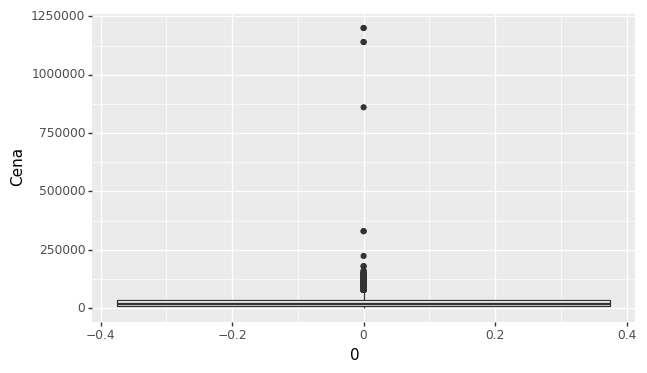

<ggplot: (8741396938216)>

In [41]:
opt.figure_size = (7, 4)
ggplot(df, aes(fill = 'Cena')) + geom_boxplot(aes(x = 0, y = 'Cena'))

In [42]:
threshold = np.quantile(df.Cena, 0.95)
threshold

70000.0

In [43]:
# drop outliers
df.drop(df.Cena[df.Cena > threshold].index, inplace=True)

In [44]:
def map_price_interval(sample_price: int, intervals: list):
    for i, (lo, hi) in enumerate(intervals):
        if lo <= sample_price <= hi:
            return i
    
    return i+1

In [45]:
price_df = pd.DataFrame(df.Cena)

for n_bins in range(5, 21):
    price_bins = np.array(jenks_breaks(df.Cena.values, n_bins))
    price_intervals = list(zip(price_bins[:-1], price_bins[1:]))
    
    price_df[f'Cenová skupina {n_bins}'] = df.Cena.apply(map_price_interval, intervals=price_intervals).astype('category')

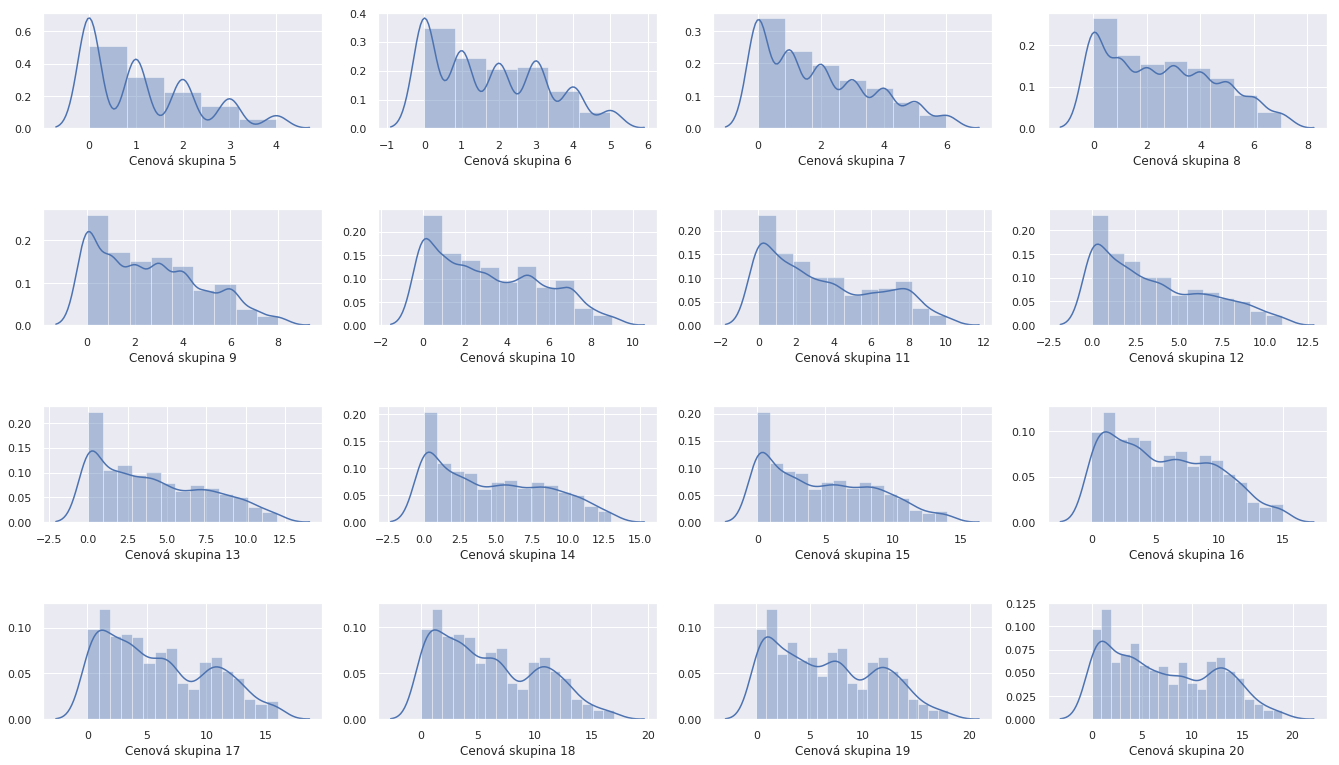

In [46]:
fig, axes = plt.subplots(4, 4, figsize=(23, 13))

plt.subplots_adjust(hspace=.7)

for i, grp in enumerate(price_df.columns[1:]):
    with sns.color_palette(n_colors=i + 5) as pal:
        ax = axes.flatten()[i]
#         ax.set_title(grp)
        
        np.random.seed(42)
#         sns.scatterplot(x=np.random.randn(len(price_df)), y='Cena', hue=grp, palette=pal, data=price_df, ax=ax, legend=False)
        sns.distplot(price_df[grp], bins=i + 5, ax=ax)

In [47]:
n_price_bins = 10  # seems reasonable and will be supported by dtreeviz

price_bins = np.array(jenks_breaks(df.Cena.values, n_price_bins))
price_intervals = list(zip(price_bins[:-1], price_bins[1:]))

df['Cenová skupina'] = df.Cena.apply(map_price_interval, intervals=price_intervals).astype('category')

In [48]:
df.drop('Cena', axis=1, inplace=True)

##### Vymera

In [49]:
def parse_area(are_str: str) -> int:
    if pd.isna(are_str):
        return 0
    
    return int(are_str[:-len("m2")].replace(" ", ""))

In [50]:
df['Výměra'] = df['Výměra'].apply(parse_area, convert_dtype='int')

In [51]:
df.drop(df[df['Výměra'] == 1].index, inplace=True)

In [52]:
def map_area_interval(sample_area: int, intervals: list):
    for i, (lo, hi) in enumerate(intervals):
        if lo <= sample_area <= hi:
            return i
    
    return i+1

In [53]:
area_df = pd.DataFrame(df['Výměra'])

for n_bins in range(5, 21):
    area_bins = np.array(jenks_breaks(df['Výměra'].values, n_bins))
    area_intervals = list(zip(area_bins[:-1], area_bins[1:]))
    
    area_df[f'Výměrová skupina {n_bins}'] = df['Výměra'].apply(map_area_interval, intervals=area_intervals).astype('category')

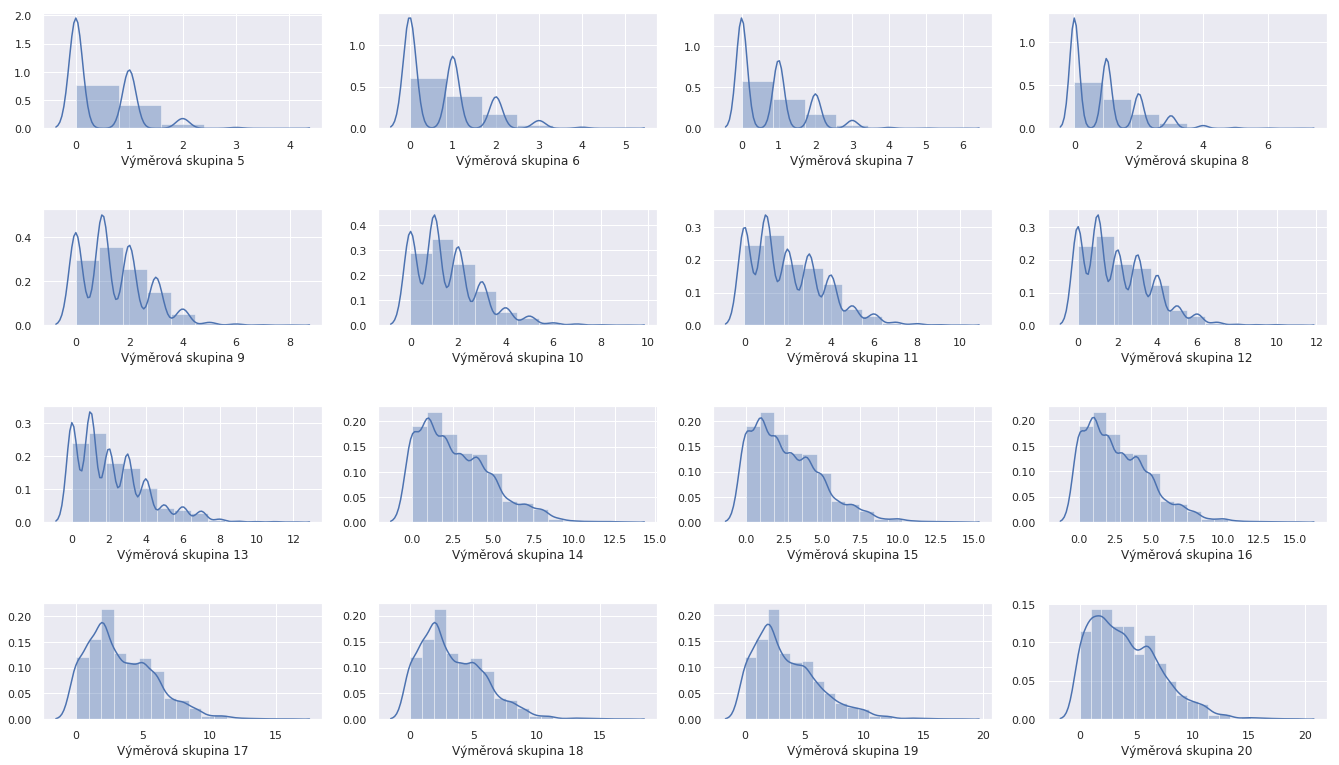

In [54]:
fig, axes = plt.subplots(4, 4, figsize=(23, 13))

plt.subplots_adjust(hspace=.7)

for i, grp in enumerate(area_df.columns[1:]):
    with sns.color_palette(n_colors=i + 5) as pal:
        ax = axes.flatten()[i]
#         ax.set_title(grp)
        
        np.random.seed(42)
#         sns.scatterplot(x=np.random.randn(len(area_df)), y='Výměra', hue=grp, palette=pal, data=area_df, ax=ax, legend=False)
        sns.distplot(area_df[grp], bins=i + 5, ax=ax)

In [55]:
n_area_bins = 20

area_bins = np.array(jenks_breaks(df['Výměra'].values, n_area_bins))
area_intervals = list(zip(area_bins[:-1], area_bins[1:]))

df['Výměrová skupina'] = df['Výměra'].apply(map_area_interval, intervals=area_intervals).astype('category')

---

In [56]:
df.drop('geometry', axis=1, inplace=True)

In [57]:
df.head(3)

,Dispozice,Energetická náročnost budovy,Kauce,Měsíční poplatky,Podlaží,Provize realitní kanceláře,Vybavený,Výměra,geo-lat,geo-lng,Balkón,Sklep,Pračka,Lednice,Myčka,Cenová skupina,Výměrová skupina
1,3,6,0,0,11,0,2,56,50.08239,14.45221,0,0,0,0,0,3,3
2,5,6,0,0,11,0,2,66,50.08868,14.38362,0,0,0,0,0,3,3
3,4,1,24000,4500,18,0,2,138,50.00192,14.34755,0,0,0,0,0,4,8


---

In [58]:
# df.drop_duplicates().to_csv('data/clean/data.csv', index=False)

---

# Feautre distribution

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
df = pd.read_csv('data/clean/data.csv')

In [61]:
labels = df.pop('Cenová skupina')
features = df

In [62]:
features.head(1)

,Dispozice,Energetická náročnost budovy,Kauce,Měsíční poplatky,Podlaží,Provize realitní kanceláře,Vybavený,Výměra,geo-lat,geo-lng,Balkón,Sklep,Pračka,Lednice,Myčka,Výměrová skupina
0,3,6,0,0,11,0,2,56,50.08239,14.45221,0,0,0,0,0,3


In [63]:
labels.head(1)

0    3
Name: Cenová skupina, dtype: int64

In [64]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.2)

In [65]:
x_train.shape

(1813, 16)

In [66]:
x_test.shape

(454, 16)

## Target variable distribution

(array([359., 220., 245., 209., 194., 220., 131., 139.,  59.,  37.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

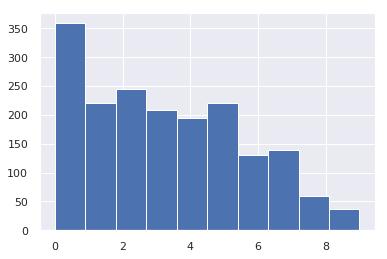

In [67]:
plt.hist(y_train)

(array([90., 55., 61., 53., 48., 55., 33., 35., 15.,  9.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

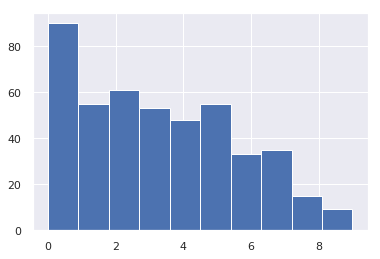

In [68]:
plt.hist(y_test)

> Distributions of test and train labels are similar (check)

---
# Model

## DecisionTre

In [69]:
from sklearn.tree import DecisionTreeClassifier

In [70]:
model = DecisionTreeClassifier()

In [71]:
model.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [72]:
param_grid = {
    'max_depth': range(10, 35, 5),
    'max_features': np.arange(0.2, 1.2, 0.2),
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': np.arange(0.0, 1.0, 0.1),
    'min_samples_leaf': np.arange(1, 5),
    'min_samples_split': np.arange(2, 5)
}

In [73]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
grid = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', n_jobs=4, cv=cv)

grid.fit(x_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': range(10, 35, 5), 'max_features': array([0.2, 0.4, 0.6, 0.8, 1. ]), 'criterion': ['gini', 'entropy'], 'min_impurity_decrease': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'min_samples_leaf': array([1, 2, 3, 4]), 'min_samples_split': array([2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [74]:
grid.best_score_

0.628099173553719

In [75]:
model = grid.best_estimator_
model

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [76]:
### Bootrstrap testing
from collections import namedtuple

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score

from scipy.stats import norm

Score = namedtuple('Score', 'accuracy sensitivity specificity')

scores = []
for _ in range(10):
    x_t, y_t = shuffle(x_test, y_test, n_samples=200)
    
    y_ = model.predict(x_t)
    
    accuracy = accuracy_score(y_t, y_)
    sensitivity = sensitivity_score(y_t, y_, average='micro')
    specificity = specificity_score(y_t, y_, average='micro')
    
    scores.append(Score(accuracy, sensitivity, specificity))

print(scores)

statistics = np.array(scores)

p = 0.95
d = norm()

alpha = 1 - p

z = d.ppf(1 - alpha/2)
sigma = statistics[:, 0].std()

ci = z * sigma / np.sqrt(len(statistics))

accuracy = statistics[:, 0].mean()

sensitivity = statistics[:, 1].mean()
specificity = statistics[:, 2].mean()

[Score(accuracy=0.605, sensitivity=0.605, specificity=0.9561111111111111), Score(accuracy=0.57, sensitivity=0.57, specificity=0.9522222222222222), Score(accuracy=0.61, sensitivity=0.61, specificity=0.9566666666666667), Score(accuracy=0.605, sensitivity=0.605, specificity=0.9561111111111111), Score(accuracy=0.665, sensitivity=0.665, specificity=0.9627777777777777), Score(accuracy=0.625, sensitivity=0.625, specificity=0.9583333333333334), Score(accuracy=0.635, sensitivity=0.635, specificity=0.9594444444444444), Score(accuracy=0.625, sensitivity=0.625, specificity=0.9583333333333334), Score(accuracy=0.615, sensitivity=0.615, specificity=0.9572222222222222), Score(accuracy=0.66, sensitivity=0.66, specificity=0.9622222222222222)]


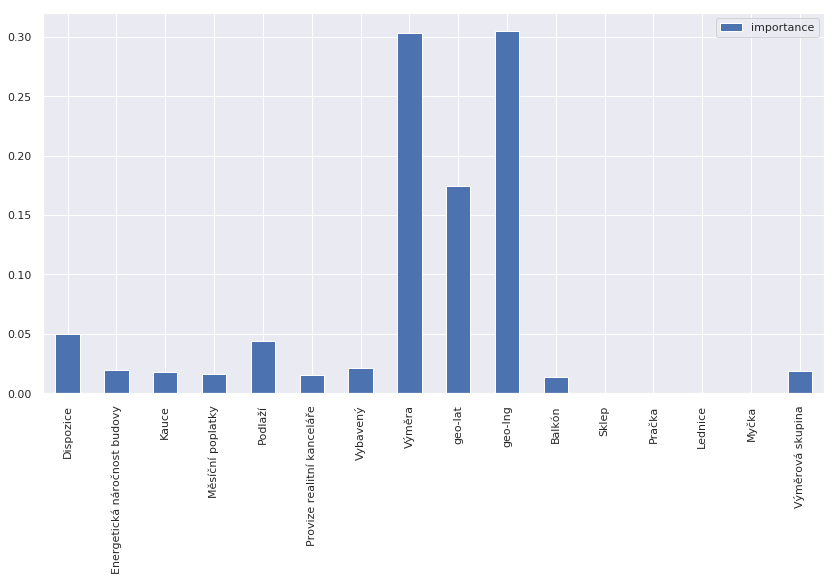

In [77]:
# _, ax = plt.subplots(figsize=(14, 7))
# pd.DataFrame([model.feature_importances_], columns=features.columns, index=['importance']).plot(kind='bar', ax=ax)

_, ax = plt.subplots(figsize=(14, 7))
pd.DataFrame(model.feature_importances_, index=features.columns, columns=['importance']).plot(kind='bar', ax=ax)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

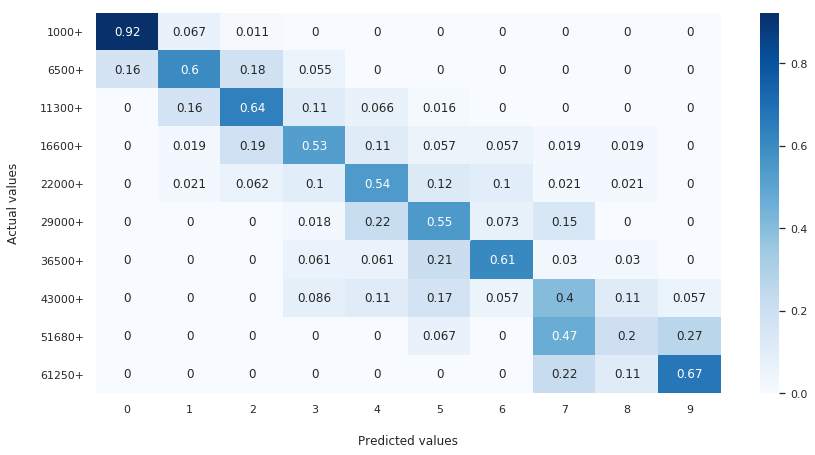

In [78]:
from sklearn.metrics import confusion_matrix

y_ = model.predict(x_test)

cm = confusion_matrix(y_test, y_)
cm = cm / np.sum(cm, axis=1)[:, np.newaxis]

np.set_printoptions(precision=2)

plt.subplots(figsize=(14, 7))
heatmap = sns.heatmap(cm, cmap='Blues', annot=True)

# heatmap.set_title("Confusion matrix for flat price classification", fontdict={'size': 17}, pad=20)
heatmap.set_xlabel("Predicted values", labelpad=20)
heatmap.set_ylabel("Actual values", labelpad=20)
heatmap.set_yticklabels(list(
    map(lambda i: f"{price_intervals[i][0].astype(int)}+", range(len(price_intervals)))
))

plt.yticks(rotation=0)

/home/macermak/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


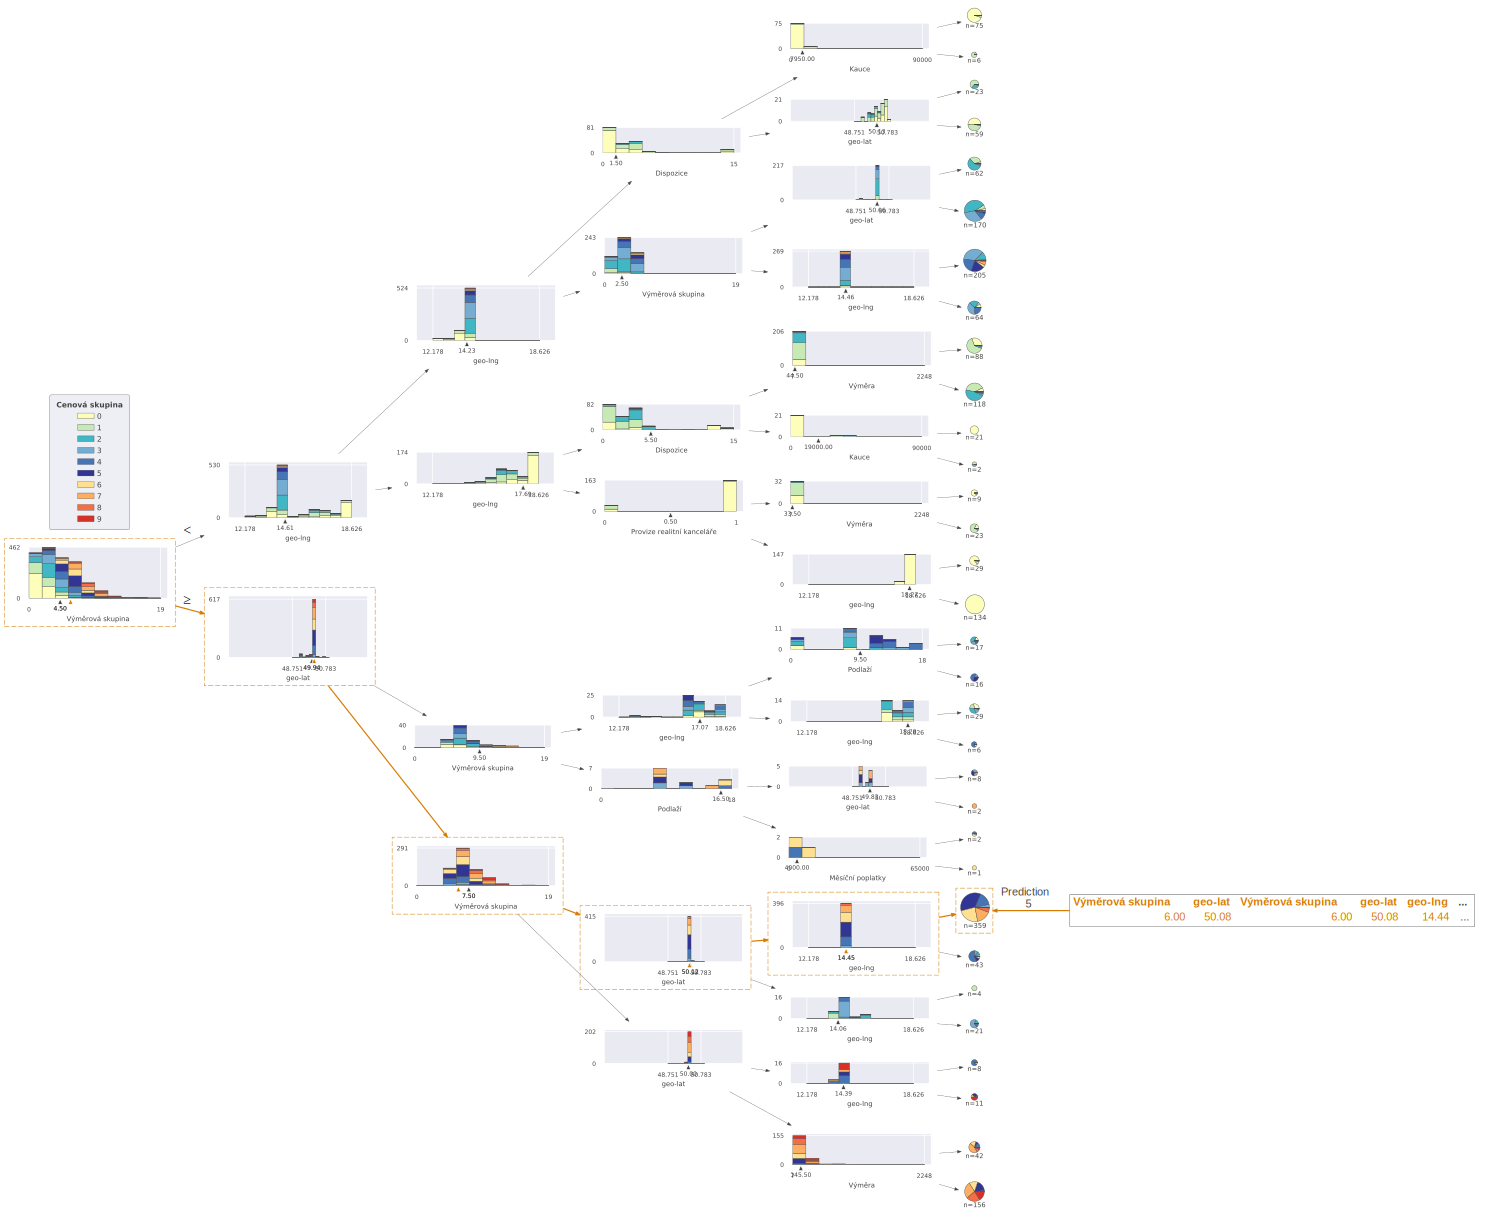

In [79]:
import graphviz
import graphviz.backend

from dtreeviz.trees import *
from IPython.display import SVG


mpl.rcParams['savefig.facecolor'] = 'white'

X = x_test.iloc[np.random.randint(0, len(x_test)), :]

tree = DecisionTreeClassifier(criterion='entropy', max_features=0.8, max_depth=5)  # limit depth of the tree for viz purposes
tree.fit(x_train, y_train)

# > WARNING: dtreeviz only supports <=10 classes, see issue: https://github.com/parrt/dtreeviz/issues/26
viz = dtreeviz(tree, x_train, y_train,
               feature_names=x_train.columns, target_name=y_train.name, class_names=list(sorted(y_train.unique())),
               orientation='LR', fancy=True, X=X)

SVG(viz.svg())

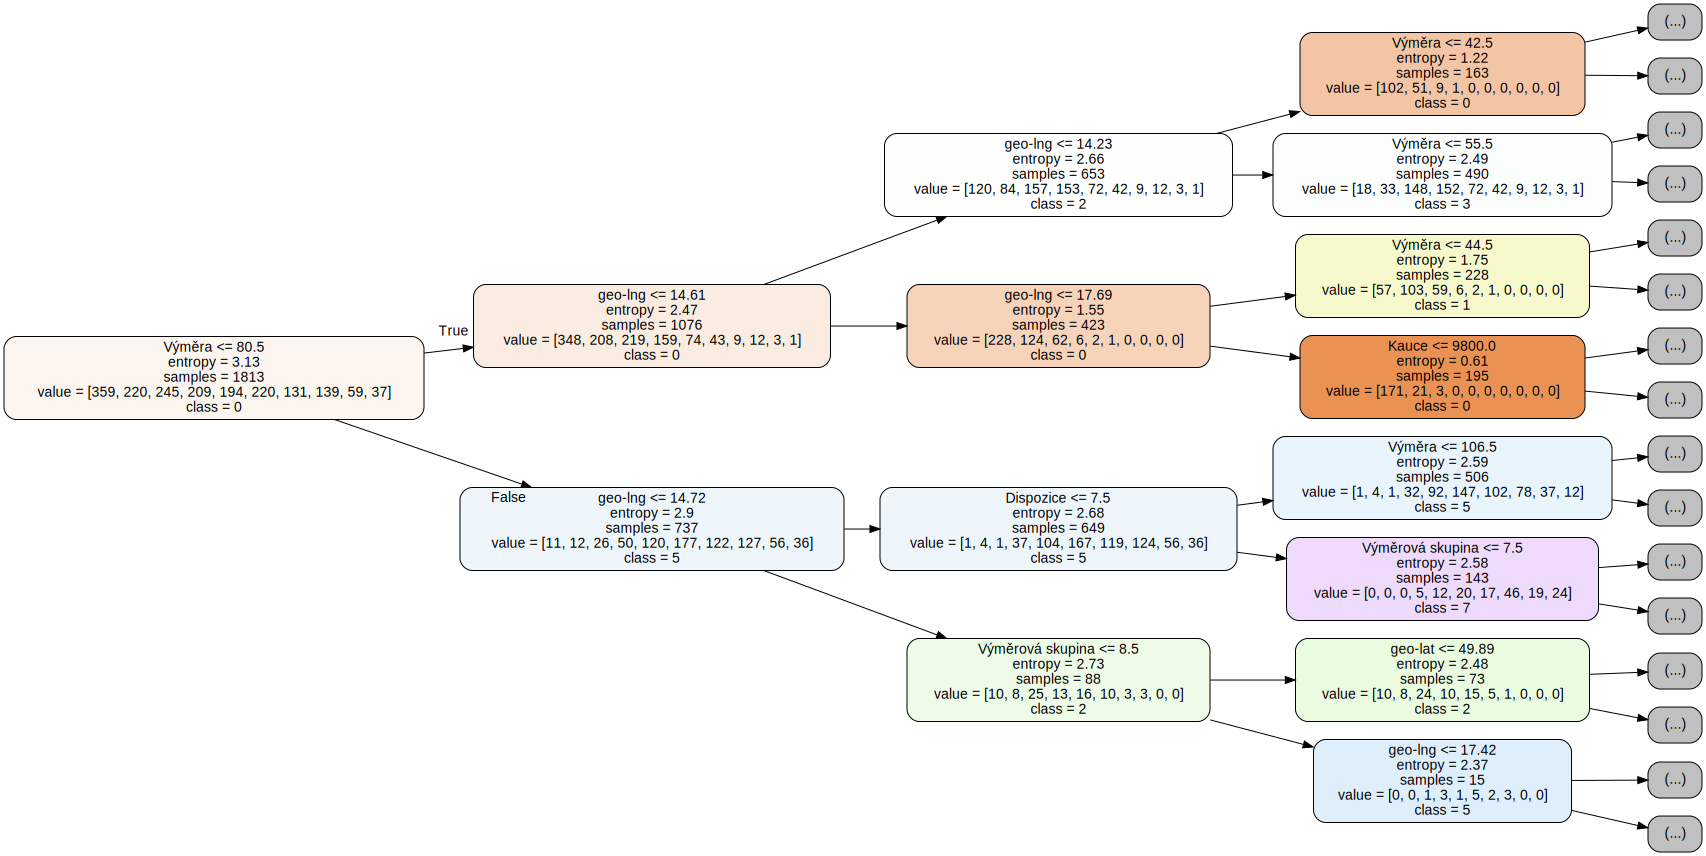

In [80]:
import graphviz

from sklearn.tree import export_graphviz

dot = export_graphviz(model, max_depth=3, feature_names=x_train.columns, class_names=list(map(str, sorted(y_train.unique()))), precision=2, rounded=True, filled=True, proportion=False, rotate=True)
viz = graphviz.Source(dot)

outfile = 'tree-complete.svg'

with open(outfile, 'w') as f:
    f.write(viz.pipe(format='svg').decode())

viz

### Evaluation results

In [81]:
print(f"""
Model evaluation:

confidence interval: {ci:.4f} computed with {p} likelihood on 10 batches of size 200.

accuracy: {accuracy:.2f} +- {ci:.4f}
sensitivity: {sensitivity:.2f}
specificity: {specificity:.2f}
""")


Model evaluation:

confidence interval: 0.0163 computed with 0.95 likelihood on 10 batches of size 200.

accuracy: 0.62 +- 0.0163
sensitivity: 0.62
specificity: 0.96



## Ensemble

In [82]:
from sklearn.ensemble import BaggingClassifier

ensemble = BaggingClassifier(model, n_estimators=10, random_state=42)
ensemble.fit(x_train, y_train)

ensemble.score(x_test, y_test)

0.6211453744493393

In [83]:
### Bootstrap testing
Score = namedtuple('Score', 'accuracy sensitivity specificity')

scores = []
for _ in range(10):
    x_t, y_t = shuffle(x_test, y_test, n_samples=200)
    
    y_ = ensemble.predict(x_t)
    
    accuracy = accuracy_score(y_t, y_)
    sensitivity = sensitivity_score(y_t, y_, average='micro')
    specificity = specificity_score(y_t, y_, average='micro')
    
    scores.append(Score(accuracy, sensitivity, specificity))

print(scores)

statistics = np.array(scores)

p = 0.95
d = norm()

alpha = 1 - p

z = d.ppf(1 - alpha/2)
sigma = statistics[:, 0].std()

ci = z * sigma / np.sqrt(len(statistics))

accuracy = statistics[:, 0].mean()

sensitivity = statistics[:, 1].mean()
specificity = statistics[:, 2].mean()

[Score(accuracy=0.65, sensitivity=0.65, specificity=0.9611111111111111), Score(accuracy=0.625, sensitivity=0.625, specificity=0.9583333333333334), Score(accuracy=0.605, sensitivity=0.605, specificity=0.9561111111111111), Score(accuracy=0.685, sensitivity=0.685, specificity=0.965), Score(accuracy=0.63, sensitivity=0.63, specificity=0.9588888888888889), Score(accuracy=0.635, sensitivity=0.635, specificity=0.9594444444444444), Score(accuracy=0.665, sensitivity=0.665, specificity=0.9627777777777777), Score(accuracy=0.58, sensitivity=0.58, specificity=0.9533333333333334), Score(accuracy=0.62, sensitivity=0.62, specificity=0.9577777777777777), Score(accuracy=0.655, sensitivity=0.655, specificity=0.9616666666666667)]


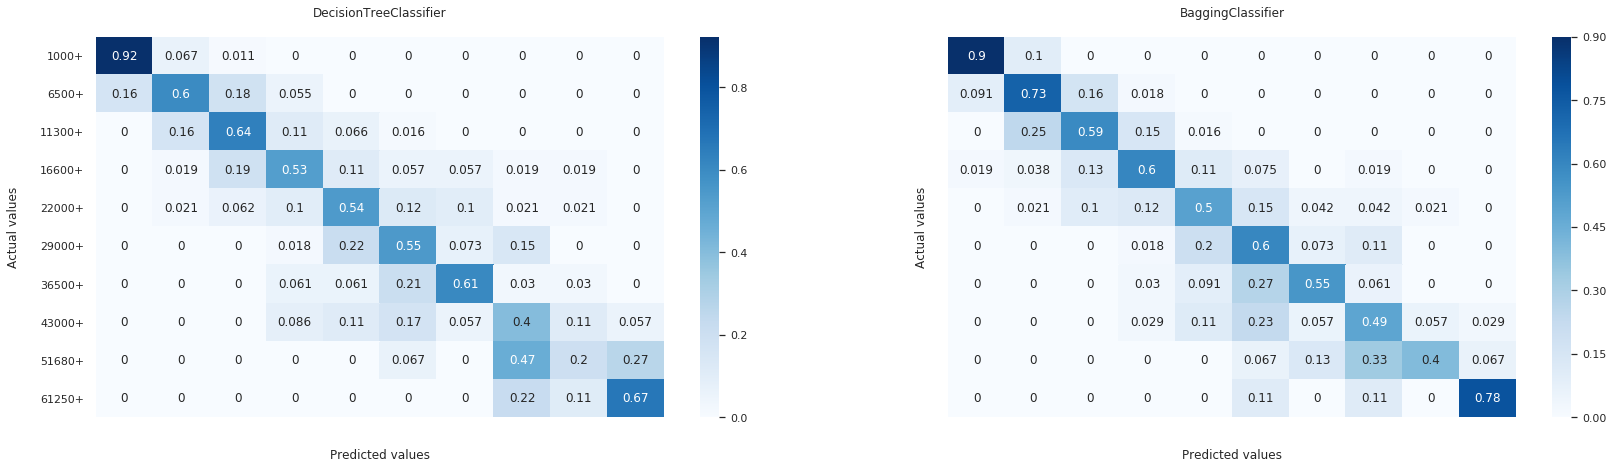

In [84]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(28, 7), sharex=True, sharey=True)

for i, estimator in enumerate([model, ensemble]):
    y_ = estimator.predict(x_test)

    cm = confusion_matrix(y_test, y_)
    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]

    np.set_printoptions(precision=2)

    heatmap = sns.heatmap(cm, cmap='Blues', annot=True, ax=axes[i])

    # heatmap.set_title("Confusion matrix for flat price classification", fontdict={'size': 17}, pad=20)
    heatmap.set_title(type(estimator).__name__, pad=20)
    heatmap.set_xlabel("Predicted values", labelpad=20)
    heatmap.set_ylabel("Actual values", labelpad=20)
    heatmap.set_xticklabels([])
    heatmap.set_yticklabels(
        list(map(lambda i: f"{price_intervals[i][0].astype(int)}+", range(len(price_intervals)))),
        rotation=0
    )

In [85]:
print(f"""
Model evaluation:

confidence interval: {ci:.4f} computed with {p} likelihood on 10 batches of size 200.

accuracy: {accuracy:.2f} +- {ci:.4f}
sensitivity: {sensitivity:.2f}
specificity: {specificity:.2f}
""")


Model evaluation:

confidence interval: 0.0179 computed with 0.95 likelihood on 10 batches of size 200.

accuracy: 0.64 +- 0.0179
sensitivity: 0.64
specificity: 0.96



## How well can we do based only on location?

In [86]:
features = df[['geo-lat', 'geo-lng']]

In [87]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.2)

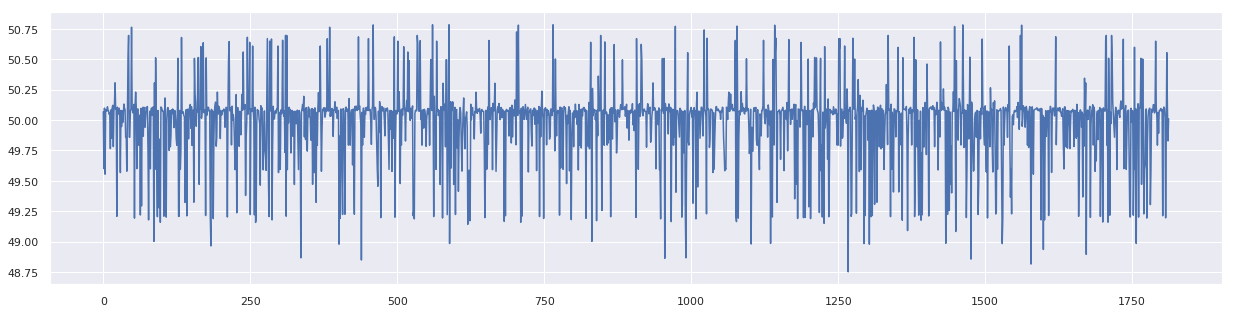

In [88]:
plt.subplots(figsize=(21, 5))
plt.plot(x_train['geo-lat'].reset_index(drop=True))

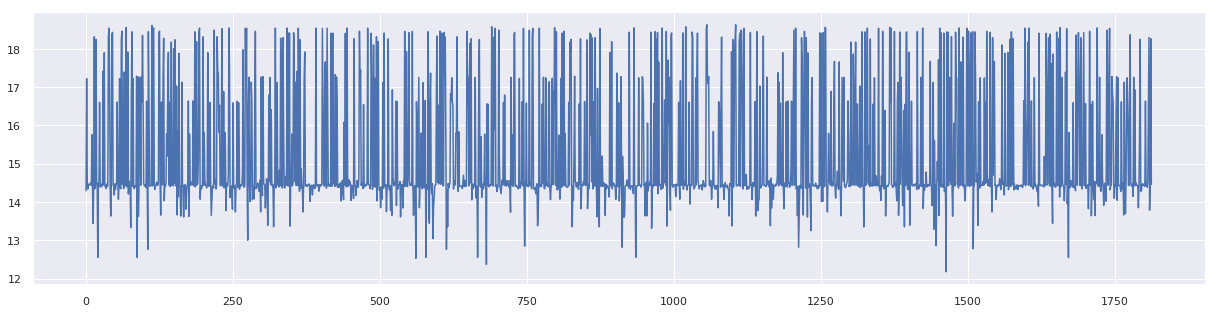

In [89]:
plt.subplots(figsize=(21, 5))
plt.plot(x_train['geo-lng'].reset_index(drop=True))

In [90]:
x_train.var()

geo-lat    0.102686
geo-lng    2.226577
dtype: float64

> Makes sense that `geo-lng` has greater variance (country shape) 

In [91]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import Perceptron, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

models = [
    DecisionTreeClassifier(), GaussianNB(), BernoulliNB(), Perceptron(), RidgeClassifier(), SVC(), LinearSVC(), RandomForestClassifier(), ExtraTreesClassifier()
]

In [92]:
scores = {}

for estimator in models:
    
    estimator.fit(x_train, y_train)
    
    estimator_scores = []
    for _ in range(10):
        
        x_t, y_t = shuffle(x_test, y_test, n_samples=200)

        y_ = estimator.predict(x_t)

        accuracy = accuracy_score(y_t, y_)
        sensitivity = sensitivity_score(y_t, y_, average='micro')
        specificity = specificity_score(y_t, y_, average='micro')

        estimator_scores.append(Score(accuracy, sensitivity, specificity))
    
    scores[type(estimator).__name__] = Score(*np.mean(estimator_scores, axis=0))

/home/macermak/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/macermak/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/macermak/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/macermak/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/fores

In [93]:
pprint(scores)

{
    'DecisionTreeClassifier': Score(
        accuracy=numpy.float64(0.6075),
        sensitivity=numpy.float64(0.6075),
        specificity=numpy.float64(0.956388888888889)
    ),
    'GaussianNB': Score(
        accuracy=numpy.float64(0.2415),
        sensitivity=numpy.float64(0.2415),
        specificity=numpy.float64(0.9157222222222222)
    ),
    'BernoulliNB': Score(
        accuracy=numpy.float64(0.19149999999999998),
        sensitivity=numpy.float64(0.19149999999999998),
        specificity=numpy.float64(0.9101666666666667)
    ),
    'Perceptron': Score(
        accuracy=numpy.float64(0.09749999999999999),
        sensitivity=numpy.float64(0.09749999999999999),
        specificity=numpy.float64(0.8997222222222223)
    ),
    'RidgeClassifier': Score(
        accuracy=numpy.float64(0.307),
        sensitivity=numpy.float64(0.307),
        specificity=numpy.float64(0.923)
    ),
    'SVC': Score(
        accuracy=numpy.float64(0.3305),
        sensitivity=numpy.float64(0.3305)

> Stick with DT

In [94]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=20)
model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [95]:
model.score(x_test, y_test)

0.5881057268722467

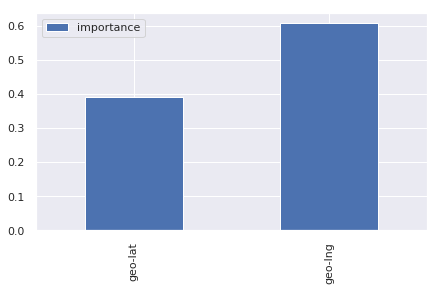

In [96]:
# _, ax = plt.subplots(figsize=(14, 7))
# pd.DataFrame([model.feature_importances_], columns=features.columns, index=['importance']).plot(kind='bar', ax=ax)

_, ax = plt.subplots(figsize=(7, 4))
pd.DataFrame(model.feature_importances_, index=features.columns, columns=['importance']).plot(kind='bar', ax=ax)

> As expected -> greater importance of `geo-lng`

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

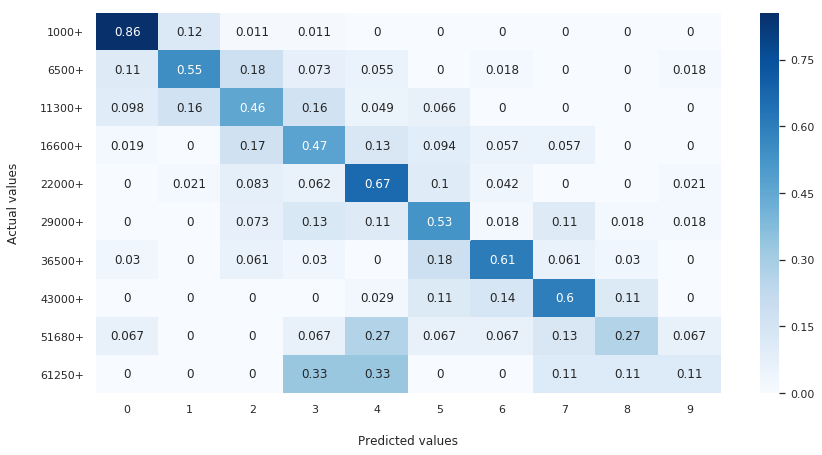

In [97]:
y_ = model.predict(x_test)

cm = confusion_matrix(y_test, y_)
cm = cm / np.sum(cm, axis=1)[:, np.newaxis]

np.set_printoptions(precision=2)

plt.subplots(figsize=(14, 7))
heatmap = sns.heatmap(cm, cmap='Blues', annot=True)

# heatmap.set_title("Confusion matrix for flat price classification", fontdict={'size': 17}, pad=20)
heatmap.set_xlabel("Predicted values", labelpad=20)
heatmap.set_ylabel("Actual values", labelpad=20)
heatmap.set_yticklabels(list(
    map(lambda i: f"{price_intervals[i][0].astype(int)}+", range(len(price_intervals)))
))

plt.yticks(rotation=0)

# Visualizations

## Decision regions

In [98]:
from functools import reduce
from shapely.geometry import *

polygons = geo_df.geometry
country_poly = reduce(lambda p, q: p.union(q), polygons)

In [99]:
plot_step = 0.05

xm, ym, xM, yM = country_poly.bounds
xx, yy = np.meshgrid(np.arange(xm, xM, plot_step), np.arange(ym, yM, plot_step))

point_grid = asMultiPoint(np.c_[xx.ravel(), yy.ravel()]).intersection(country_poly)

x_ = np.array(point_grid)
y_ = model.predict(x_[:, [1, 0]])

In [100]:
df_pred = gpd.GeoDataFrame({'prediction': y_}, geometry=list(map(Point, x_)))

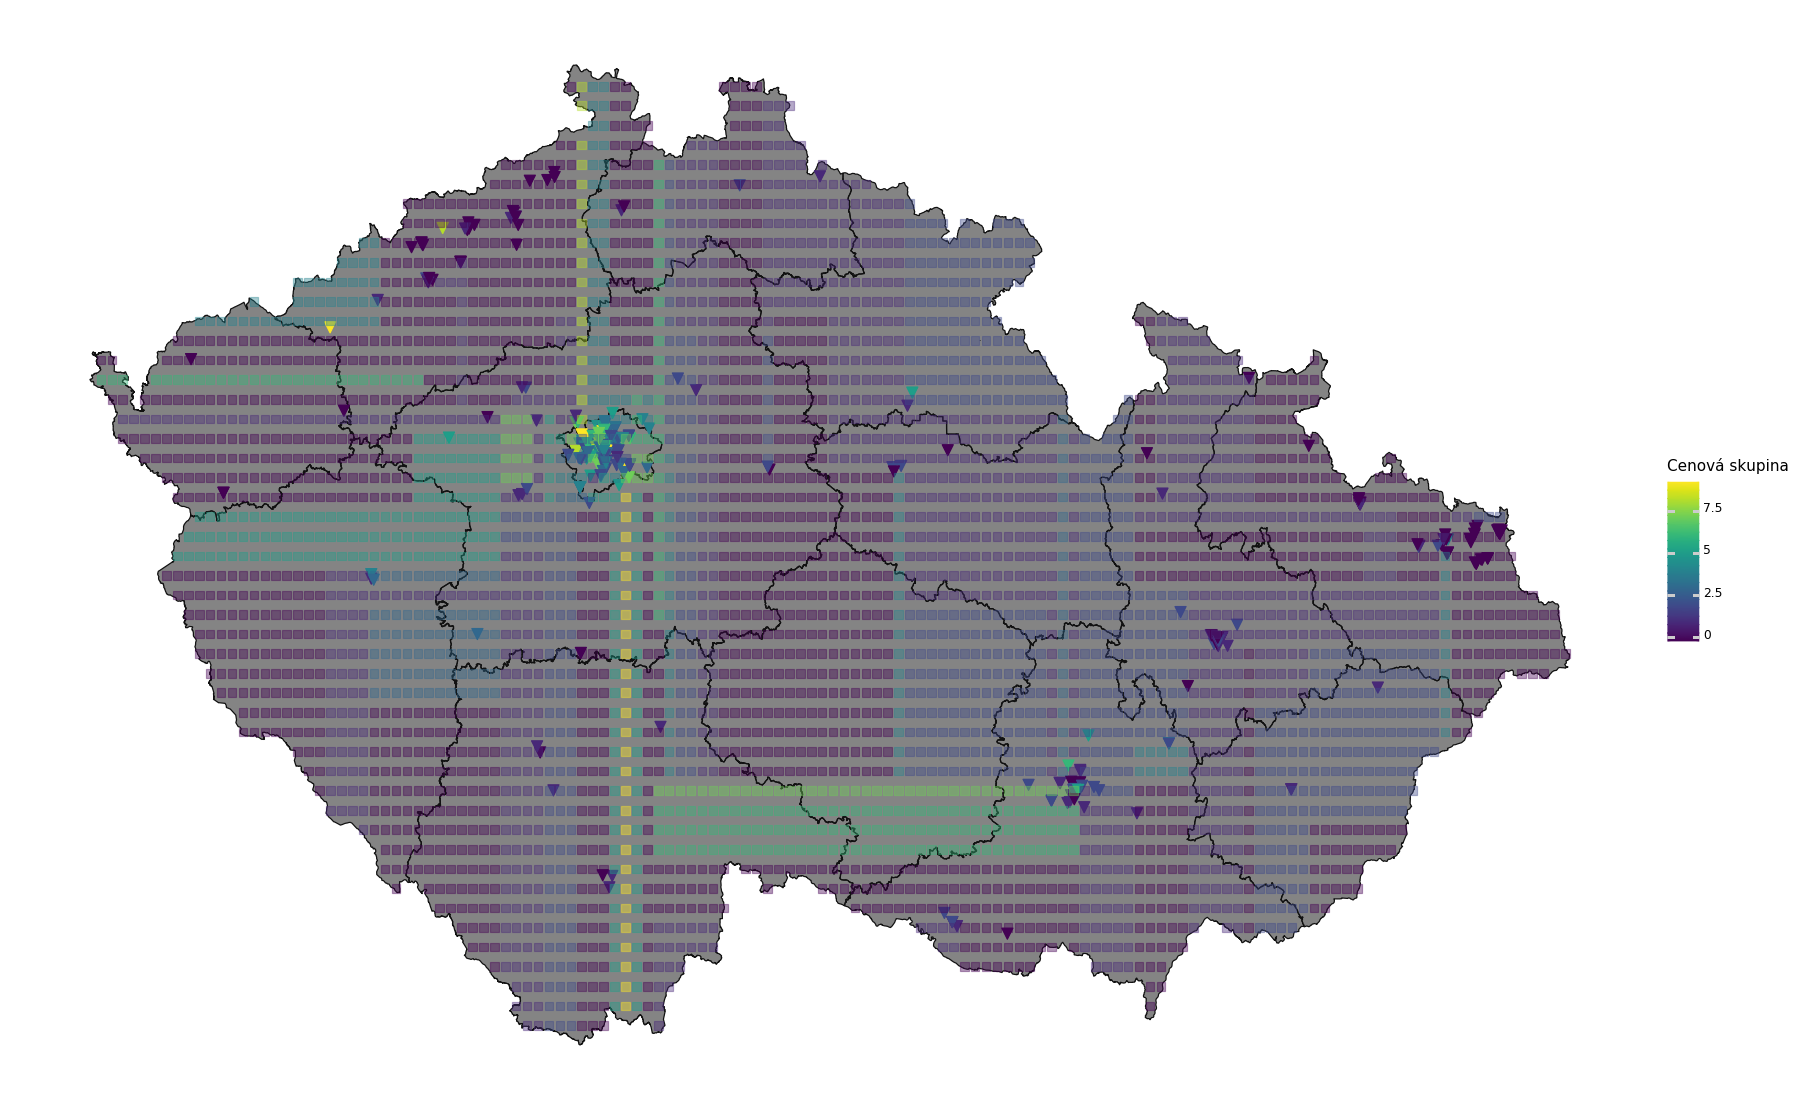

<ggplot: (-9223363295480840227)>

In [117]:
opt.figure_size = (21, 14)

price_values = list(map(lambda i: ' ÷ '.join(map(str, map(int, price_intervals[i]))), y_test))
predicted_values = map(lambda i: ' ÷ '.join(map(str, map(int, price_intervals[i]))), y_)

price_categories = map(lambda i: ' ÷ '.join(map(str, map(int, price_intervals[i]))), range(len(price_intervals)))

(ggplot(geo_df)
 + geom_map(alpha=0.6)
 + geom_point(x_test, aes(x='geo-lng', y='geo-lat', color=y_test), size=4, shape='v', alpha=1)
 + geom_point(df_pred, aes(x='geometry.x', y='geometry.y', color='prediction'), shape='s', size=3, alpha=0.4)
 + labs(color='Cenová skupina')
 + theme_void()
)